<a href="https://colab.research.google.com/github/Samuelturak/Semestral-thesis/blob/main/Semestral_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and mounting





In [ ]:
from scipy.io import loadmat
from pandas import factorize
import pandas as pd
import pickle
import h5py
import numpy as np
import random
import os
import gc
from scipy import signal

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
#from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Defined functions for easier work with data

Many of these functions were used or were inspired from the original author:
https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb


## Functions to load datasets

In [ ]:
# RadioML2016.10a/10b or MIGOU MOD

def load_dataset(dataset_location):
    """
    Load dataset and extract needed data

    Input:
        dataset_location: specify where the file is stored and its name

    Output:
        snrs: list of the SNR range in dataset [-20 to 18]
        X: array of the measured I/Q data [num_of_samples, 128, 2]
        modulations: list of the modulations in this dataset
        one_hot_encode: one_hot encoded data - the other maps the order of the mods
        lbl_SNR: list of each snr (for plotting)
    """

    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset_location.keys())))), [1,0])

    X = []; I = []; Q = []; lbl = [];

    for mod in mods:
        for snr in snrs:
            X.append(dataset_location[(mod,snr)])
            for i in range(dataset_location[(mod,snr)].shape[0]):
                lbl.append((mod,snr))
    X = np.vstack(X); lbl=np.vstack(lbl)

    X = np.transpose(X[:,:,:],(0,2,1))

    # One-hot-encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)



    return snrs, X, mods, one_hot_encode, lbl_SNR

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

In [ ]:
# RML2016.10b / just for the way it is saved in my GoogleDrive

def load_RMLb_dataset(X, lbl):
    mods = np.unique(lbl[:,0])
    snrs = np.unique(lbl[:,1])
    snrs = list(map(int, snrs))
    snrs.sort()

    # One-hot encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)


    # Assign SNR value to each vector
    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)

    X = X


    return snrs, X, mods, one_hot_encode, lbl_SNR

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

## Functions to handle the datasets

In [ ]:
def train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15):

    """
    Train-Test split the data

    Input:
        X: X data
        one_hot: Y data encoded to one_hot
        train_split (default 0.7)
        valid_split (default 0.15)
        test_split (default 0.15)
        train_split : valid_split : test_split - ratio for splitting the dataset

        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data
        test_idx: indexes from X assinged to test data
        X_train: X data assigned for training
        X_valid: X data assigned for validation
        X_test: X data assigned for testing
        Y_train: one-hot encoded Y data assigned for training
        Y_valid: one-hot encoded Y data assigned for validation
        Y_test: one-hot encoded Y data assigned for testing
    """

    # Set random seed
    np.random.seed(42)
    random.seed(42)

    # Get the number of samples
    n_examples = X.shape[0]
    n_train = int(n_examples * train_split)
    n_valid = int(n_examples * valid_split)
    n_test = int(n_examples * test_split)

    # Get indexes of train data
    train_idx = np.random.choice(range(0, n_examples), size=n_train, replace=False)

    # Left indexes for valid and test sets
    left_idx= list(set(range(0, n_examples)) - set(train_idx))

    # Get indexes for the left indexes of the X data
    val = np.random.choice(range(0, (n_valid+n_test)), size=(n_valid), replace=False)
    test = list(set(range(0, len(left_idx))) - set(val))

    # Assign indeces for validation to left indexes
    valid_idx = []
    for i in val:
        val_idx = left_idx[i]
        valid_idx.append(val_idx)

    # Get the test set as the rest indexes
    test_idx = []
    for i in test:
        tst_idx = left_idx[i]
        test_idx.append(tst_idx)

    # Shuffle the valid_idx and test_idx
    random.shuffle(valid_idx)
    random.shuffle(test_idx)

    # Assing the indexes to the X and Y data to create train and test sets
    X_train = X[train_idx]
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    Y_train = one_hot[train_idx]
    Y_valid = one_hot[valid_idx]
    Y_test = one_hot[test_idx]

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

In [ ]:
def normalize_data(X_train, X_valid, X_test):
        # mean-std normalization

    mean = X_train[:,:,:].mean(axis=0)  # calculating mean
    X_train[:,:,:] -= mean              # substracting with mean
    std = X_train[:,:,:].std(axis=0)    # calculating standard deviation
    X_train[:,:,:] /= std               # dividing by standard


    X_valid[:,:,:] -= mean              # substracting with mean
    X_valid[:,:,:] /= std               # dividing by standard

    X_test[:,:,:] -= mean               # substracting with mean
    X_test[:,:,:] /= std                # dividing by standard

    return X_train, X_valid, X_test

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

In [ ]:
def return_indices_of_a(a, b):
    """
    Compare two lists a, b for same items and return indeces
    of the item in list a

    a:    List of items, its indeces will be returned
    b:    List of items to search for in list a

    Credit: https://stackoverflow.com/users/97248/pts ; https://stackoverflow.com/questions/10367020/compare-two-lists-in-python-and-return-indices-of-matched-values
    """
    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

## Functions for plotting

In [ ]:
def show_confusion_matrix(validations, predictions, matrix_snr, save=False):
    """
    Plot confusion matrix

    validations:    True Y labels
    predictions:    Predicted Y labels of your model
    matrix_snr:     SNR information for plot's titel
    """

    cm = confusion_matrix(validations, predictions)
    # Normalise
    # Update ro prevent division by zero
    cm_sum = cm.sum(axis=1)[:, np.newaxis]
    cmn = np.divide(cm.astype('float'), cm_sum, where=cm_sum!=0)

    #cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(13,13))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', annot_kws={"size": 20}, xticklabels=mods, yticklabels=mods)
    sns.set(font_scale=1.3) #(1.3 before)

    # Allow tittle
    #if matrix_snr == None:
    #    plt.title("Confusion Matrix", fontsize=25)
    #else:
    #    plt.title("Confusion Matrix \n" + str(matrix_snr) + "dB", fontsize=20)
    # Change the size of labels

    plt.ylabel('True Label', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=20)

    # Set the tick labels font size and rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate xticklabels to 0 degrees (horizontal)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Rotate yticklabels to 0 degrees (horizontal)

    # Set the tick labels font size
    ax.tick_params(axis='both', which='major', labelsize=20)

    # Customize legend
    #legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                       #fancybox=True, shadow=True, ncol=5, prop={'size': 10})

    if save == True:
        plt.savefig(base_dir + 'Own_dataset/' + str(matrix_snr) + '.png')
    plt.show(block=False)

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

In [ ]:
def All_SNR_show_confusion_matrix(X_test, save=False):
    """
    Plot confusion matrix of all SNRs in one

    X_test:   X_test data
    """
    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))

    show_confusion_matrix(Y_Test, Y_Pred, None, save)

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

In [ ]:
def SNR_show_confusion_matrix(in_snr, lbl_SNR, X_test, save=False):
    """
    Plot confusion matrices of chosen SNRs
    """
    for snr in in_snr:
        matrix_snr = snr
        Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = [];
        matrix_snr_index = [];

        prediction = model.predict(X_test)

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        for i in range(len(lbl_SNR)):
            if int(lbl_SNR[i]) == matrix_snr:
                matrix_snr_index.append(i)

        if not matrix_snr_index:
            print(f"No matching SNR found for {matrix_snr}")
            continue

        indeces_of_Y_test = return_indices_of_a(test_idx, matrix_snr_index)

        if not indeces_of_Y_test:
            print(f"No indices found in test_idx for SNR {matrix_snr}")
            continue

        for i in indeces_of_Y_test:
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])

        if not Y_Pred_SNR or not Y_Test_SNR:
            print(f"No predictions or test labels found for SNR {matrix_snr}")
            continue

        show_confusion_matrix(Y_Test_SNR, Y_Pred_SNR, matrix_snr, save)

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

In [ ]:
def plot_split_distribution(mods, Y_train, Y_valid, Y_test):

    x = np.arange(len(mods))  # the label locations
    width = 1  # the width of the bars

    fig, ax = plt.subplots()
    bar1 = ax.bar(x-width*0.3, np.count_nonzero(Y_train == 1, axis=0), width*0.3, label = "Train")
    bar2 = ax.bar(x , np.count_nonzero(Y_valid == 1, axis=0), width*0.3, label = "Valid")
    bar3 = ax.bar(x+width*0.3, np.count_nonzero(Y_test == 1, axis=0), width*0.3, label = "Test")


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Modulations', fontsize=15)
    ax.set_ylabel('Distribution', fontsize=15)
    ax.set_title('Distribution overview of splitted dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(mods, rotation=45)
    ax.legend()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            #fancybox=True, shadow=True, ncol=5)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # autolabel(bar1)
    # autolabel(bar2)
    # autolabel(bar3)
    # fig.tight_layout()
    return plt.show()


    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

In [ ]:
def plot_snr_distribution(train_idx, valid_idx, test_idx, lbl_SNR):
    # Create bins from -10 to 20 with an increment of 2
    bins = np.arange(-20, 21, 2)  # 22 is used as the upper limit to include 20 (-10, 23, 2) before (-22, 23, 2)

    # Calculate the histogram data for each set
    snr_train_hist, _ = np.histogram(lbl_SNR[train_idx], bins=bins)
    snr_valid_hist, _ = np.histogram(lbl_SNR[valid_idx], bins=bins)
    snr_test_hist, _ = np.histogram(lbl_SNR[test_idx], bins=bins)

    # Set up the bar width and positions
    width = 0.3  # the width of the bars
    x = np.arange(len(bins) - 1)  # the label locations

    fig, ax = plt.subplots()
    ax.bar(x - width, snr_train_hist, width, label='Train')
    ax.bar(x, snr_valid_hist, width, label='Validation')
    ax.bar(x + width, snr_test_hist, width, label='Test')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('SNR [dB]', fontsize=15)
    ax.set_ylabel('Distribution', fontsize=15)
    ax.set_title('SNR Distribution across Train, Validation, and Test Sets')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{bins[i]}' for i in range(len(bins) - 1)], rotation=45)
    ax.legend()
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
        #fancybox=True, shadow=True, ncol=5)
    plt.show()

# Example usage:
# plot_snr_distribution(lbl_SNR, train_idx, valid_idx, test_idx)

In [ ]:
def SNR_accuracy(in_snr, name):
    """
    Computes accuracies of chosen SNRs individualy

    in_snr:   must be list of SNRs
    """

    acc = []
    for snr in in_snr:
        acc_snr = snr
        idx_acc_snr = []

        for i in range(len(test_idx)):
            if int(lbl_SNR[test_idx[i]]) == int(acc_snr):
                idx_acc_snr.append(i)

        acc_X_test = X_test[idx_acc_snr]
        # acc_X_f_test = X_f_test[idx_acc_snr]
        acc_Y_test = Y_test[idx_acc_snr]

        print('\nSNR ' + str(acc_snr) + 'dB:')
        accuracy_snr = model.evaluate([acc_X_test], acc_Y_test, batch_size=32, verbose=2)
        acc.append(accuracy_snr)

    acc = np.vstack(acc)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(SNR, (acc[:,1]*100), 'steelblue', marker='.', markersize= 15, label = name, linestyle = '-',)
    #ax.legend(loc=4, prop={'size': 15}) #25 before

    x_major_ticks = np.arange(-20, 19, 2 )            # arranging range of ticks (-20, 18, 2 ) before (-10, 21, 5 ) (0, 21, 2 )
    ax.set_xticks(x_major_ticks)

    y_major_ticks = np.arange(0, 101, 10 )
    y_minor_ticks = np.arange(0, 101, 2)
    ax.set_yticks(y_major_ticks)
    ax.set_yticks(y_minor_ticks, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=16) # 20 before, changes the size of the numbers
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate xticklabels to 0 degrees (horizontal)

    ax.grid(which='both',color='lightgray', linestyle='-')

    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

    plt.xlim(-21, 19) # (-20, 18) before (-12, 22)
    plt.ylim(0,100)
    #plt.title("Classification Accuracy",fontsize=20)
    plt.ylabel('Accuracy [%]',fontsize=20) #(20 before)
    plt.xlabel('SNR [dB]',fontsize=20) #(20 before)
    # plt.savefig(base_dir + name + '.png')
    plt.show()

    return acc[:,1]


    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

## Functions for visualization of layers

In [ ]:
def layer_overview(model):

    """
    Offers overview of the model's layers and theirs outputs

    model: specify trained model you want to have overview of
    """

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    return layer_names, layer_outputs

def model_visualization(nth_layer, nth_test_idx, mods, model,
                        plot_sample = False, plot_activations = True,
                        plot_feature_maps = True):

    """
    The function provised overview of activation of specific layer and its
    feature maps.

    nth_layer: enter number which corresponds with the position of wanted layer
    nth_test_idx: enter number pointing at the test indexes from earlier
    mods: provide variable which holds listed modulations
    model: specify which trained model to load
    plot_sample = False: set to true to plot sample data
    plot_activations = True: plots activation of chosen layer
    plot_feature_maps = True: plots feature map of chosen layer
    """

    # Sample data for visualization
    test_sample = X_test[nth_test_idx,:,:] # shape [128,2]
    test_sample = test_sample[None] # change to needed [1,128,2]
    SNR = lbl_SNR[test_idx[nth_test_idx]]
    mod = one_hot[test_idx[nth_test_idx]]
    f, u = factorize(mods)
    mod = mod.dot(u)

    # Names and outputs from layers
    layer_names = [layer.name for layer in model.layers]
    layer_outputs = [layer.output for layer in model.layers[:]]

    ## Activations ##

    # define activation model
    activation_model = tf.keras.models.Model(model.input, layer_outputs)

    # get the activations of chosen test sample
    activations = activation_model.predict(test_sample)

    ## Feature-maps ##

    # define feature maps model
    feature_maps_model = tf.keras.models.Model(model.inputs, model.layers[4].output)

    # get the activated features
    feature_maps = feature_maps_model.predict(test_sample)


    # Plot sample
    if plot_sample == True:
        plt.plot(test_sample[0,:,:])
        plt.title(mod + '    ' + str(SNR) + 'dB')
        plt.show()

    # Plot activations
    if plot_activations == True:
        activation_layer = activations[nth_layer]
        activation_layer = np.transpose(activation_layer[:,:,:],(0,2,1)) # reshape
        fig, ax = plt.subplots(figsize=(20,10))
        ax.matshow(activation_layer[0,:,:],  cmap='viridis')
        # plt.matshow(activation_layer[0,:,:],  cmap='viridis')
        plt.title('Activation of layer ' + layer_names[nth_layer])
        ax.grid(False)
        ax.set_xlabel('Lenght of sequence')
        ax.set_ylabel('Filters')
        fig.show()
        plt.savefig(base_dir + 'activations.png')
        plt.savefig(base_dir + 'activations.svg')

    # Plot feature maps
    if plot_feature_maps == True:
        n_filters = int(feature_maps.shape[2]/2); ix = 1
        fig = plt.figure(figsize=(25,15))
        for _ in range(n_filters):
            for _ in range(2):
                # specify subplot and turn of axis
                ax =fig.add_subplot(n_filters,  5, ix)
                # ax = plt.subplot(n_filters,  5, ix, )
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                ax.plot(feature_maps[0, :, ix-1])
                ix += 1
        # show the figure
        fig.show()
        plt.savefig(base_dir + 'feature_map.png')
        plt.savefig(base_dir + 'feature_map.svg')

    """
    Credit goes to the original author:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

# Import the datasets

## RadioML Dataset 2018 (This is unfunctional)


*  O'shea, Timothy J., and Nathan West. "Radio machine learning dataset generation with gnu radio." Proceedings of the GNU Radio Conference. Vol. 1. No. 1. 2016.

* The datasets are available at:  https://www.deepsig.ai/datasets  

*  All datasets provided by Deepsig Inc. are licensed under the Creative Commons Attribution -  [NonCommercial - ShareAlike 4.0 License (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/).


In [ ]:
#from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data framing check


In [ ]:
import h5py
#dataset_pkl = open('RML2016.10a_dict.pkl','rb')
#dataset_pkl = open('/content/drive/MyDrive/ColabNotebooks/GOLD_XYZ_OSC.0001_1024.hdf5','rb')
#RML_dataset_location = pickle.load(dataset_pkl, encoding='bytes')
file_path = '/content/drive/MyDrive/ColabNotebooks/GOLD_XYZ_OSC.0001_1024.hdf5'

with h5py.File(file_path, 'r') as file:
    # ChatGPT dit it:
    items = list(file.keys())

    for item in items:
        print(f"Item: {item}")

        # Check if it's a dataset or a group
        if isinstance(file[item], h5py.Dataset):
            # If it's a dataset, print its shape and data type
            print(f"  Shape: {file[item].shape}")
            print(f"  Data Type: {file[item].dtype}")
        elif isinstance(file[item], h5py.Group):
            # If it's a group, list the items inside the group
            subitems = list(file[item].keys())
            print(f"  Subitems: {subitems}")

Item: X
  Shape: (2555904, 1024, 2)
  Data Type: float32
Item: Y
  Shape: (2555904, 24)
  Data Type: int64
Item: Z
  Shape: (2555904, 1)
  Data Type: int64


### Data decimation

In [ ]:
import h5py
file_path = '/content/drive/MyDrive/ColabNotebooks/GOLD_XYZ_OSC.0001_1024.hdf5'
# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Access the dataset
    x_data = file['X']
    y_data = file['Y']
    z_data = file['Z']

    # Print the first 10 elements as an example
    print(x_data[0:10])
    print(y_data[0:10])
    print(z_data[0:10])

    # Decimating the data:
    x_data = file['X']
    y_data = file['Y']
    z_data = file['Z']

    x_decimated = [x for i, x in enumerate(x_data) if (i + 1) % 10 != 0]
    y_decimated = [y for i, y in enumerate(y_data) if (i + 1) % 10 != 0]
    z_decimated = [z for i, z in enumerate(z_data) if (i + 1) % 10 != 0]

    # Print the first 10 elements of the decimated data as an example
    print("\nDecimated Data:")
    print(x_decimated[0:10])
    print(y_decimated[0:10])
    print(z_decimated[0:10])

    x_array = np.array(x_decimated)
    y_array = np.array(y_decimated)
    z_array = np.array(z_decimated)

    # Select every tenth element
    #x_array = np.array(x_data[::10])
    #y_array = np.array(y_data[::10])
    #z_array = np.array(z_data[::10])

    # Select every third element
    #x_array = np.array(x_data[::10])
    #y_array = np.array(y_data[::10])
    #z_array = np.array(z_data[::10])

    # Select paths
    x_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X_decimated.pkl'
    y_pkl_path = '/content/drive/MyDrive/ColabNotebooks/Y_decimated.pkl'  # Not using this as for now
    z_pkl_path = '/content/drive/MyDrive/ColabNotebooks/Z_decimated.pkl'  # Not using this as for now

    # Save to .pkl files
    with open(x_pkl_path, 'wb') as X:
      pickle.dump(x_array, X)
    # Not using this as for now
    with open(y_pkl_path, 'wb') as Y:
      pickle.dump(y_array, Y)
    # Not using this as for now
    with open(z_pkl_path, 'wb') as Z:
      pickle.dump(z_array, Z)

[[[ 0.0420274   0.23476323]
  [-0.2728826   0.40513492]
  [-0.26707262  0.22749889]
  ...
  [-0.7055947  -0.28693035]
  [-0.41157472  0.66826206]
  [ 0.06487698  0.6358149 ]]

 [[ 1.198624    0.4493616 ]
  [ 0.48543093  0.28272954]
  [ 0.8679219  -0.33194578]
  ...
  [-1.2129315  -0.64293194]
  [-0.38100415  0.793629  ]
  [ 0.0864124   1.0921808 ]]

 [[-0.22345497  0.18144214]
  [ 0.06201788 -0.934319  ]
  [ 0.71949023  0.21791682]
  ...
  [ 0.7598529   0.00820714]
  [ 0.3396765   0.12928951]
  [ 0.58232504  0.10775959]]

 ...

 [[ 0.08048291 -0.8901321 ]
  [-0.19014871  0.5693468 ]
  [-0.8060696   0.377975  ]
  ...
  [-0.03769325  1.1753614 ]
  [ 0.40794492  0.16862743]
  [-0.39616418 -0.46701407]]

 [[-0.22437388  1.1258712 ]
  [-0.85063404  0.13241269]
  [ 0.3664085  -0.49992895]
  ...
  [ 0.01005393  0.4310479 ]
  [-0.85562956 -0.08321918]
  [ 0.7112126  -0.94285434]]

 [[ 0.4275345  -0.39440805]
  [ 0.799718    0.09637037]
  [-0.16939726 -0.46497536]
  ...
  [-0.21386544  0.425272

### Creating Chunks (outdated)

In [ ]:
import h5py
import numpy as np
import pickle
import gc

file_path = '/content/drive/MyDrive/ColabNotebooks/GOLD_XYZ_OSC.0001_1024.hdf5'

# Define a function to process data in chunks and save
def save_in_chunks(dataset, pkl_path, chunk_size=100000):
    num_entries = len(dataset)
    for i in range(0, num_entries, chunk_size):
        end = min(i + chunk_size, num_entries)
        data_chunk = np.array(dataset[i:end])
        chunk_file_path = f"{pkl_path}_chunk_{i//chunk_size}.pkl"
        with open(chunk_file_path, 'wb') as f:
            pickle.dump(data_chunk, f)
        del data_chunk
        gc.collect()

# Open the HDF5 file
with h5py.File(file_path, 'r') as file:
    # Access the dataset
    x_data = file['X']
    y_data = file['Y']
    z_data = file['Z']

    # Print the first 10 elements as an example
    print(x_data[0:10])
    print(y_data[0:10])
    print(z_data[0:10])

    # Base paths
    x_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X'
    y_pkl_path = '/content/drive/MyDrive/ColabNotebooks/Y'
    z_pkl_path = '/content/drive/MyDrive/ColabNotebooks/Z'

    save_in_chunks(x_data, x_pkl_path)
    #save_in_chunks(y_data, y_pkl_path)
    #save_in_chunks(z_data, z_pkl_path)


[[[ 0.0420274   0.23476323]
  [-0.2728826   0.40513492]
  [-0.26707262  0.22749889]
  ...
  [-0.7055947  -0.28693035]
  [-0.41157472  0.66826206]
  [ 0.06487698  0.6358149 ]]

 [[ 1.198624    0.4493616 ]
  [ 0.48543093  0.28272954]
  [ 0.8679219  -0.33194578]
  ...
  [-1.2129315  -0.64293194]
  [-0.38100415  0.793629  ]
  [ 0.0864124   1.0921808 ]]

 [[-0.22345497  0.18144214]
  [ 0.06201788 -0.934319  ]
  [ 0.71949023  0.21791682]
  ...
  [ 0.7598529   0.00820714]
  [ 0.3396765   0.12928951]
  [ 0.58232504  0.10775959]]

 ...

 [[ 0.08048291 -0.8901321 ]
  [-0.19014871  0.5693468 ]
  [-0.8060696   0.377975  ]
  ...
  [-0.03769325  1.1753614 ]
  [ 0.40794492  0.16862743]
  [-0.39616418 -0.46701407]]

 [[-0.22437388  1.1258712 ]
  [-0.85063404  0.13241269]
  [ 0.3664085  -0.49992895]
  ...
  [ 0.01005393  0.4310479 ]
  [-0.85562956 -0.08321918]
  [ 0.7112126  -0.94285434]]

 [[ 0.4275345  -0.39440805]
  [ 0.799718    0.09637037]
  [-0.16939726 -0.46497536]
  ...
  [-0.21386544  0.425272

### Checking files

In [ ]:
x_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X.pkl'
y_pkl_path = '/content/drive/MyDrive/ColabNotebooks/Y.pkl'
z_pkl_path = '/content/drive/MyDrive/ColabNotebooks/Z.pkl'

# Open and load the pickle file for inspection
with open(x_pkl_path, 'rb') as x_file:
    x_data = pickle.load(x_file)
    print(x_data)

with open(y_pkl_path, 'rb') as y_file:
    y_data = pickle.load(y_file)
    print(y_data)

with open(z_pkl_path, 'rb') as z_file:
    z_data = pickle.load(z_file)
    print(z_data)


FileNotFoundError: ignored

Download in case stored datasets don't work

In [ ]:
# RadioML2016.10b stored in X.pkl and label.pkl
# First one is not working
#!gdown --id 10OdxNvtSbOm58t-MMHZcmSMqzEWDSpAr
!gdown --id 1-MvVKNmTfqyfYD_usvAfEcizzBX0eEpE

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=10OdxNvtSbOm58t-MMHZcmSMqzEWDSpAr 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-MvVKNmTfqyfYD_usvAfEcizzBX0eEpE
To: /content/labels.pkl
100% 14.4M/14.4M [00:00<00:00, 227MB/s]


### Downsample (already done)

In [ ]:
x_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X.pkl'

with open(x_pkl_path, 'rb') as x_file:
    X = pickle.load(x_file)

#X = pickle.load(open(x_pkl_path, 'rb'))

# ChatGPT helped:
# reduce from 1024 samples to a smaller number
downsampling_factor = 8

# Calculate the new number of samples after downsampling
new_sample_count = X.shape[1] // downsampling_factor

# Create an empty array to store the downsampled data
downsampled_data = np.empty((X.shape[0], new_sample_count, X.shape[2]))

# Perform downsampling by taking the mean of the specified number of samples
for i in range(new_sample_count):
    start = i * downsampling_factor
    end = (i + 1) * downsampling_factor
    downsampled_data[:, i, :] = np.mean(X[:, start:end, :], axis=1)

# Saving the downsampled data to a different file
downsampled_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X_downsampled.pkl'
with open(downsampled_pkl_path, 'wb') as X_downsampled:
    pickle.dump(downsampled_data, X_downsampled)

### Downsample chunks, but ended up with the last chunk only (doesn't work)

In [ ]:
# GPT-4 did this
import gc
def downsample_chunk(chunk, downsampling_factor):
    new_sample_count = chunk.shape[1] // downsampling_factor
    downsampled_chunk_data = np.empty((chunk.shape[0], new_sample_count, chunk.shape[2]))

    for i in range(new_sample_count):
        start = i * downsampling_factor
        end = (i + 1) * downsampling_factor
        downsampled_chunk_data[:, i, :] = np.mean(chunk[:, start:end, :], axis=1)

    return downsampled_chunk_data


import os

downsampling_factor = 8
x_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X'
downsampled_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X_downsampled.pkl'

# Create or overwrite the downsampled file
with open(downsampled_pkl_path, 'wb') as f:
    pass

chunk_id = 0
while True:
    chunk_file_path = f"{x_pkl_path}_chunk_{chunk_id}.pkl"
    if os.path.exists(chunk_file_path):
        with open(chunk_file_path, 'rb') as x_file:
            chunk = pickle.load(x_file)

        downsampled_chunk = downsample_chunk(chunk, downsampling_factor)
        del chunk  # delete the original chunk to free memory

        # Append the downsampled chunk to the downsampled file
        with open(downsampled_pkl_path, 'ab') as f:
            pickle.dump(downsampled_chunk, f)

        del downsampled_chunk  # free memory
        gc.collect()

        chunk_id += 1
    else:
        break


### Checking out the content

In [ ]:
from pprint import pformat
import pickle

label_path = '/content/labels.pkl'
X_path = '/content/drive/MyDrive/ColabNotebooks/RML2016.10b.dat'



with open(X_path, "rb") as file:
    data = pickle.load(file, encoding='latin1')
#print(data.keys())

key = ('QPSK', 2)
print(type(data[key]))
print(data[key])



#with open(X_path, 'rb') as file:
    #data = pickle.load(file)
#data = np.unique(labels)
#print(data.shape)
#print(data)

# Convert to DataFrame for easier manipulation
#df = pd.DataFrame(data, columns=['Modulation', 'SNR'])

# Group by Modulation and then count the occurrences of each SNR value
#grouped = df.groupby('Modulation')['SNR'].value_counts().unstack(fill_value=0)

#print(grouped)

<class 'numpy.ndarray'>
[[[-0.00752281 -0.00561562 -0.00440028 ... -0.00504063 -0.00317084
   -0.00575482]
  [ 0.00401368  0.00268561  0.00128211 ...  0.01040219  0.00717842
    0.00407615]]

 [[-0.00175093  0.00083702 -0.0017455  ...  0.0007172   0.00457201
   -0.00031692]
  [-0.00236791  0.00021756  0.00128363 ...  0.00915462  0.00923191
    0.0058996 ]]

 [[-0.00080115 -0.001983   -0.00523791 ...  0.00054467 -0.00441528
   -0.00581296]
  [-0.00993724 -0.00555279 -0.00793912 ... -0.00114739  0.00020742
   -0.00279285]]

 ...

 [[-0.00211105 -0.00788133 -0.00693202 ... -0.00876567 -0.00567301
   -0.00481623]
  [-0.00229169 -0.00789739 -0.0040146  ... -0.00816608 -0.00845601
   -0.00462616]]

 [[-0.00366602 -0.00209228 -0.00727246 ...  0.00878922  0.00967124
    0.00749018]
  [-0.0058285  -0.00236692 -0.00523868 ... -0.00222952 -0.00399149
   -0.00025299]]

 [[-0.00700829 -0.00629576 -0.00349915 ...  0.00687257  0.00315842
    0.00270952]
  [-0.00533853 -0.00883489 -0.00900123 ... -0.0

### Downsampling and Merging chunks into 3 bigger chunks (outdated)

In [ ]:
import numpy as np
import pickle
import os
import gc

def downsample_chunk(chunk, factor):
    new_sample_count = chunk.shape[1] // factor
    downsampled = np.empty((chunk.shape[0], new_sample_count, chunk.shape[2]))
    for i in range(new_sample_count):
        start = i * factor
        end = (i + 1) * factor
        downsampled[:, i, :] = np.mean(chunk[:, start:end, :], axis=1)
    return downsampled

# Paths
x_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X'
final_downsampled_path = '/content/drive/MyDrive/ColabNotebooks/X_final_downsampled_2.pkl'
downsampling_factor = 8
total_chunks = 26

# Initialize an empty list to append downsampled chunks
downsampled_data_list = []
# Process Each Chunk
for i in range(20, total_chunks):
    # Load each chunk
    chunk_path = f"{x_pkl_path}_chunk_{i}.pkl"
    with open(chunk_path, 'rb') as file:
        chunk = pickle.load(file)

    # Downsample
    downsampled_chunk = downsample_chunk(chunk, downsampling_factor)

    # Append the downsampled data to the list
    downsampled_data_list.append(downsampled_chunk)

    # Clear memory
    del chunk
    del downsampled_chunk
    gc.collect()

# Convert list to numpy array
final_data = np.concatenate(downsampled_data_list, axis=0)

# Save the final downsampled data
with open(final_downsampled_path, 'wb') as file:
    pickle.dump(final_data, file)

del downsampled_data_list
gc.collect()


0

### Merging the last 3 downsampled files together (will not work, too much data for RAM)

In [ ]:
x__downsampled_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X_final_downsampled'
final_downsampled_path = '/content/drive/MyDrive/ColabNotebooks/X_final_downsampled.pkl'

# Initialize an empty list to append downsampled chunks
downsampled_data_list = []
for i in range(2):
    # Load each chunk
    chunk_path = f"{x__downsampled_pkl_path}_{i}.pkl"
    with open(chunk_path, 'rb') as file:
        chunk = pickle.load(file)

    # Append the downsampled data to the list
    downsampled_data_list.append(chunk)

    # Clear memory
    del chunk
    gc.collect()

    # Convert list to numpy array
    full_downsampled_data = np.concatenate(downsampled_data_list, axis=0)
    print(full_downsampled_data.shape)
# Save the final downsampled data
with open(final_downsampled_path, 'wb') as file:
    pickle.dump(full_downsampled_data, file)

del downsampled_data_list
gc.collect()

(1000000, 128, 2)


In [ ]:
import pickle

final_downsampled_path = '/content/drive/MyDrive/ColabNotebooks/X_final_downsampled.pkl'

# Paths for the large downsampled chunks
chunks_paths = [
    "/content/drive/MyDrive/ColabNotebooks/X_final_downsampled_0.pkl",
    "/content/drive/MyDrive/ColabNotebooks/X_final_downsampled_1.pkl",
    "/content/drive/MyDrive/ColabNotebooks/X_final_downsampled_2.pkl"
]

# Load and concatenate
downsampled_data_list = [pickle.load(open(chunk, 'rb')) for chunk in chunks_paths]
full_downsampled_data = np.concatenate(downsampled_data_list, axis=0)

with open(final_downsampled_path, 'wb') as file:
    pickle.dump(full_downsampled_data, file)

print(full_downsampled_data.shape)


In [ ]:
downsampled_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X_final_downsampled.pkl'
with open(downsampled_pkl_path, 'rb') as xdown_file:
    X_downsampled = pickle.load(xdown_file)
X_downsampled.shape

(1000000, 128, 2)

### Loading the X data and label data

In [ ]:
import pandas

downsampled_pkl_path = '/content/drive/MyDrive/ColabNotebooks/X_downsampled.pkl'
labels_pkl_path = '/content/drive/MyDrive/ColabNotebooks/Y.pkl'


# Loading data into RMLb_X
with open(downsampled_pkl_path, 'rb') as x_file:
    RMLb_X = pickle.load(x_file, encoding='bytes')
print(RMLb_X.shape)


# Loading data from labels.pkl to RMLb_lbl
with open(labels_pkl_path, 'rb') as file:
    RMLb_lbl = pickle.load(file)

print(RMLb_lbl)
print(RMLb_lbl.shape)


(2555904, 128, 2)
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
(2555904, 24)


## RadioML Dataset 2016b

*  O'shea, Timothy J., and Nathan West. "Radio machine learning dataset generation with gnu radio." Proceedings of the GNU Radio Conference. Vol. 1. No. 1. 2016.

* The datasets are available at:  https://www.deepsig.ai/datasets  

*  All datasets provided by Deepsig Inc. are licensed under the Creative Commons Attribution -  [NonCommercial - ShareAlike 4.0 License (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/).


### Data framing check

In [ ]:
import pickle

file_path = '/content/drive/MyDrive/ColabNotebooks/RML2016.10b.dat'

try:
    # Open the file in binary mode
    with open(file_path, 'rb') as file:
        # Attempt to unpickle the file content
        try:
            data = pickle.load(file)
        except UnicodeDecodeError:
            # If a UnicodeDecodeError occurs, try a different encoding
            file.seek(0)  # Reset file pointer to the beginning
            data = pickle.load(file, encoding='latin1')

    # Process the data as before

except Exception as e:
    print(f"An error occurred: {e}")

# Check if data is a dictionary and print shapes of its elements
if isinstance(data, dict):
    for key in data:
        print(f"Shape of data[{key}]:", data[key].shape)
else:
    # If it's not a dictionary, just print the shape of data
    print("Shape of data:", data.shape)

Shape of data[('QPSK', 2)]: (6000, 2, 128)
Shape of data[('PAM4', 8)]: (6000, 2, 128)
Shape of data[('AM-DSB', -4)]: (6000, 2, 128)
Shape of data[('GFSK', 6)]: (6000, 2, 128)
Shape of data[('QAM64', 8)]: (6000, 2, 128)
Shape of data[('PAM4', 18)]: (6000, 2, 128)
Shape of data[('QAM64', -6)]: (6000, 2, 128)
Shape of data[('QAM16', 2)]: (6000, 2, 128)
Shape of data[('QAM16', -20)]: (6000, 2, 128)
Shape of data[('8PSK', -18)]: (6000, 2, 128)
Shape of data[('PAM4', -6)]: (6000, 2, 128)
Shape of data[('WBFM', -18)]: (6000, 2, 128)
Shape of data[('BPSK', 8)]: (6000, 2, 128)
Shape of data[('CPFSK', 10)]: (6000, 2, 128)
Shape of data[('WBFM', 6)]: (6000, 2, 128)
Shape of data[('BPSK', 4)]: (6000, 2, 128)
Shape of data[('BPSK', -2)]: (6000, 2, 128)
Shape of data[('QPSK', -20)]: (6000, 2, 128)
Shape of data[('CPFSK', -8)]: (6000, 2, 128)
Shape of data[('QAM64', -20)]: (6000, 2, 128)
Shape of data[('QAM16', 12)]: (6000, 2, 128)
Shape of data[('GFSK', -20)]: (6000, 2, 128)
Shape of data[('CPFSK', 

In [ ]:
import numpy as np

# Assuming 'data' is your loaded dataset
# Initialize containers
X_file = []
Y_file = []
Z_file = []

# Iterate through the dataset
for (modulation, SNR), signals in data.items():
    # Append the I/Q data
    X_file.append(signals)
    # Append the modulation label for each signal in this group
    Y_file.extend([modulation] * len(signals))
    # Append the SNR value for each signal in this group
    Z_file.extend([SNR] * len(signals))

# Convert to numpy arrays for easier handling later
X_file = np.array(X_file)
Y_file = np.array(Y_file)
Z_file = np.array(Z_file)

# Reshape X_file to merge all signal data into one array
X_file = np.vstack(X_file)


# Optionally, print shapes to verify
print("Shape of X_file:", X_file.shape)
print("Shape of Y_file:", Y_file.shape)
print("Shape of Z_file:", Z_file.shape)



Shape of X_file: (1200000, 2, 128)
Shape of Y_file: (1200000,)
Shape of Z_file: (1200000,)


In [ ]:
# Transposing
RMLb_X = X_file.transpose(0,2,1)
print("Shape of RMLb_X:", RMLb_X.shape)

RMLb_lbl = np.array(list(zip(Y_file, Z_file)))
print("Shape of RMLb_lbl:", RMLb_lbl[12000:18000])
print("Shape of RMLb_lbl:", RMLb_lbl.shape)

Shape of RMLb_X: (1200000, 128, 2)
Shape of RMLb_lbl: [['AM-DSB' '-4']
 ['AM-DSB' '-4']
 ['AM-DSB' '-4']
 ...
 ['AM-DSB' '-4']
 ['AM-DSB' '-4']
 ['AM-DSB' '-4']]
Shape of RMLb_lbl: (1200000, 2)


## Matlab dataset
This is a dataset created by me using matlab

In [ ]:
import numpy as np

# Path to the .dat file
file_path = '/content/drive/MyDrive/ColabNotebooks/Created_dataset_3_short.dat'

# Original shape of the data
original_shape = (2000, 2, 128)  # Update this based on the actual shape

# Open and read the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Processing the data
data = {}
current_key = ''
for line in lines:
    if line.startswith('Data for '):
        # This is a header line indicating a new data key
        current_key = line.strip().split(' ')[-1]  # Extract the key
        data[current_key] = []
    else:
        # This is a data line
        numbers = [float(num) for num in line.split()]
        if numbers:
            data[current_key].extend(numbers)

# Convert lists to numpy arrays and reshape
for key in data:
    data[key] = np.array(data[key]).reshape(original_shape)
    print(f"Shape of data for {key}: {data[key].shape}")

# Now `data` is a dictionary with keys as field names and values as numpy arrays with their original shape


Shape of data for PSK4_0:: (2000, 2, 128)
Shape of data for PSK4_10:: (2000, 2, 128)
Shape of data for PSK4_12:: (2000, 2, 128)
Shape of data for PSK4_14:: (2000, 2, 128)
Shape of data for PSK4_16:: (2000, 2, 128)
Shape of data for PSK4_18:: (2000, 2, 128)
Shape of data for PSK4_2:: (2000, 2, 128)
Shape of data for PSK4_20:: (2000, 2, 128)
Shape of data for PSK4_4:: (2000, 2, 128)
Shape of data for PSK4_6:: (2000, 2, 128)
Shape of data for PSK4_8:: (2000, 2, 128)
Shape of data for PSK8_0:: (2000, 2, 128)
Shape of data for PSK8_10:: (2000, 2, 128)
Shape of data for PSK8_12:: (2000, 2, 128)
Shape of data for PSK8_14:: (2000, 2, 128)
Shape of data for PSK8_16:: (2000, 2, 128)
Shape of data for PSK8_18:: (2000, 2, 128)
Shape of data for PSK8_2:: (2000, 2, 128)
Shape of data for PSK8_20:: (2000, 2, 128)
Shape of data for PSK8_4:: (2000, 2, 128)
Shape of data for PSK8_6:: (2000, 2, 128)
Shape of data for PSK8_8:: (2000, 2, 128)
Shape of data for QAM16_0:: (2000, 2, 128)
Shape of data for QAM

In [ ]:
import numpy as np
import re  # Regular expressions module

# Assuming 'data' is your loaded dataset
# Initialize containers
X_file = []
Y_file = []
Z_file = []

# Iterate through the dataset
for key, signals in data.items():
    # Split the key to extract modulation and SNR
    parts = key.split('_')
    modulation = parts[0]  # The modulation type is the first part
    # Combine the remaining parts for SNR and handle minus sign
    SNR_str = '_'.join(parts[1:])
    # Remove non-numeric characters
    SNR_str = SNR_str.replace('_', '-')  # Replace '__' with '-' for negative SNR
    SNR_str = re.sub(r'[^\d-]', '', SNR_str)

    if SNR_str.startswith('_'):  # Check if SNR is negative
        SNR = -int(SNR_str[1:])  # Convert to negative integer
    else:
        SNR = int(SNR_str)  # Convert to integer

    # Append the I/Q data
    X_file.append(signals)
    # Append the modulation label for each signal in this group
    Y_file.extend([modulation] * len(signals))
    # Append the SNR value for each signal in this group
    Z_file.extend([SNR] * len(signals))

# Convert to numpy arrays for easier handling later
X_file = np.array(X_file)
Y_file = np.array(Y_file)
Z_file = np.array(Z_file)

# Reshape X_file to merge all signal data into one array
X_file = np.vstack(X_file)

# Optionally, print shapes to verify
print("Shape of X_file:", X_file.shape)
print("Shape of Y_file:", Y_file.shape)
print("Shape of Z_file:", Z_file.shape)




Shape of X_file: (110000, 2, 128)
Shape of Y_file: (110000,)
Shape of Z_file: (110000,)


In [ ]:
# Transposing
RMLb_X = X_file.transpose(0,2,1)
print("Shape of RMLb_X:", RMLb_X.shape)

RMLb_lbl = np.array(list(zip(Y_file, Z_file)))
print("RMLb_lbl:", RMLb_lbl[108000:110000])
print("Shape of RMLb_lbl:", RMLb_lbl.shape)

Shape of RMLb_X: (110000, 128, 2)
RMLb_lbl: [['QAM64' '8']
 ['QAM64' '8']
 ['QAM64' '8']
 ...
 ['QAM64' '8']
 ['QAM64' '8']
 ['QAM64' '8']]
Shape of RMLb_lbl: (110000, 2)


# Data preprocessing













## For DeepSig Dataset 2016b

In [ ]:
# 10a
#SNR, X, modulations, one_hot, lbl_SNR = load_dataset('/content/drive/MyDrive/ColabNotebooks/GOLD_XYZ_OSC.0001_1024.hdf5')

# 10b
SNR, X, modulations, one_hot, lbl_SNR = load_RMLb_dataset(RMLb_X, RMLb_lbl)
#SNR - list of SNRs
#X - all the data
#modulations - list of modulations in strings
#one_hot - modulation one-hot-encoded (all)
#lbl_SNR - list of SNRs (all)


#print(SNR)
#print(X.shape)
print(modulations)
print(one_hot[128000:130000])
print(one_hot.shape)
#print(lbl_SNR.shape)

['8PSK' 'AM-DSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64' 'QPSK'
 'WBFM']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1200000, 10)


In [ ]:
# encoding isnt necessary for 2016b and Created dataset, but now only for 2018 downloaded labels
#mods = []
#for i in range(len(modulations)):
    #modu = modulations[i].decode('utf-8')
    #mods.append(modu)

mods = []
for i in range(len(modulations)):
    modu = modulations[i]
    mods.append(modu)

print(mods)

['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)
#print(X_train)
#print(X_train.shape)


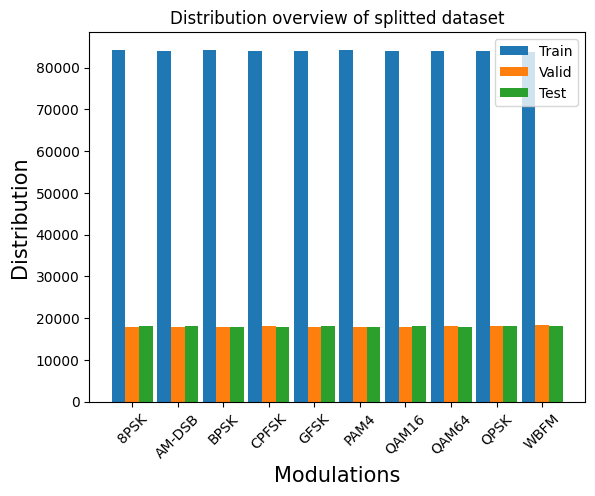

In [ ]:
plot_split_distribution(mods, Y_train, Y_valid, Y_test)

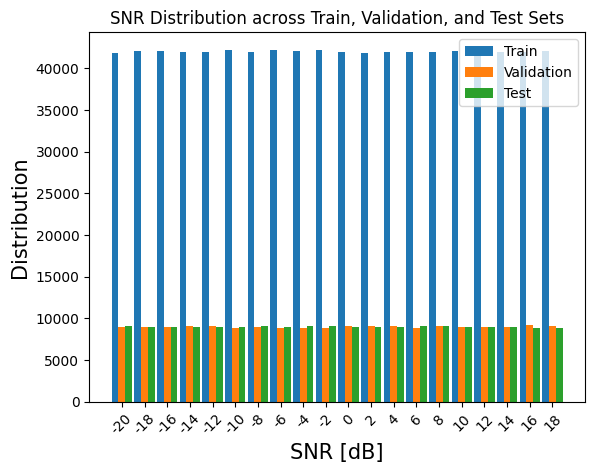

In [ ]:
plot_snr_distribution(train_idx, valid_idx, test_idx, lbl_SNR)

In [ ]:
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)
print(X_train)
print(X_train.shape)


[[[ 1.15046    -0.5436699 ]
  [ 1.0738336  -0.5159415 ]
  [ 1.0415341  -0.6667166 ]
  ...
  [-0.3442212   1.3822045 ]
  [-0.5025786   1.2996721 ]
  [-0.55405676  1.2802725 ]]

 [[-0.279196   -1.2828453 ]
  [ 0.37216082  0.00628928]
  [-0.01519915 -0.42957625]
  ...
  [-0.05771823 -0.4553614 ]
  [ 0.4938271   1.8015301 ]
  [ 0.4006982   2.2063067 ]]

 [[-2.490804   -0.18531872]
  [-0.7590002  -0.38869396]
  [-1.3711452   0.11371092]
  ...
  [ 1.909994   -1.6093752 ]
  [ 0.23783141  0.9163344 ]
  [-1.526234   -1.0665083 ]]

 ...

 [[-1.8879669  -0.40053338]
  [ 0.01914238 -0.713938  ]
  [-1.217789   -0.66234744]
  ...
  [ 1.0205907   0.2988021 ]
  [ 0.4227383  -0.1035469 ]
  [-0.7453936  -0.36122254]]

 [[-1.6269127   1.4019463 ]
  [-1.3650943   1.2936213 ]
  [-1.2625443   0.9291741 ]
  ...
  [-0.2503528  -0.16001946]
  [ 0.53479975 -0.40299168]
  [ 0.70288527 -0.6256635 ]]

 [[ 1.5802516   0.87931335]
  [ 1.5984612   0.9127887 ]
  [ 1.529338    0.7749119 ]
  ...
  [-0.94369173  1.367916

## For Matlab dataset

In [ ]:
# 10a
#SNR, X, modulations, one_hot, lbl_SNR = load_dataset('/content/drive/MyDrive/ColabNotebooks/GOLD_XYZ_OSC.0001_1024.hdf5')

# 10b
SNR, X, modulations, one_hot, lbl_SNR = load_RMLb_dataset(RMLb_X, RMLb_lbl)
#SNR - list of SNRs
#X - all the data
#modulations - list of modulations in strings
#one_hot - modulation one-hot-encoded (all)
#lbl_SNR - list of SNRs (all)


print(SNR)
print(X.shape)
print(modulations)
print(one_hot[32000:34000])
print(one_hot.shape)
print(lbl_SNR.shape)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
(110000, 128, 2)
['PSK4' 'PSK8' 'QAM16' 'QAM256' 'QAM64']
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
(110000, 5)
(110000,)


In [ ]:
# encoding isnt necessary for 2016b and Created dataset, but now only for 2018 downloaded labels
#mods = []
#for i in range(len(modulations)):
    #modu = modulations[i].decode('utf-8')
    #mods.append(modu)

mods = []
for i in range(len(modulations)):
    modu = modulations[i]
    mods.append(modu)

print(mods)

['PSK4', 'PSK8', 'QAM16', 'QAM256', 'QAM64']


In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15)
# Y_test, Y_train, Y_valid are one-hot-encoded

#print(X_train)
#print(X_train.shape)
print(Y_test[1:1000])
#print(Y_test.shape)
#print(Y_train)
#print(lbl_SNR.shape)


[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


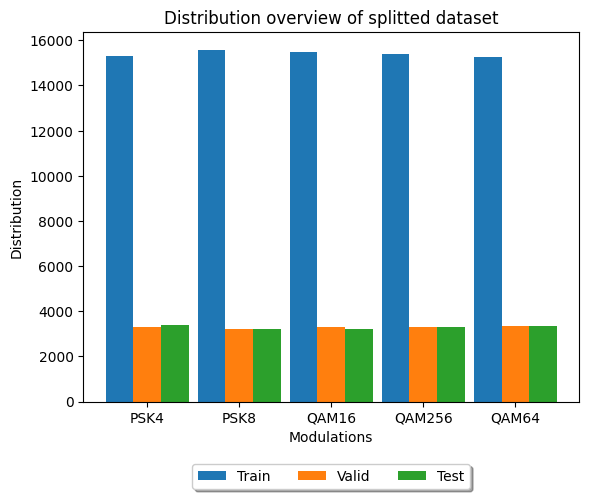

In [ ]:
plot_split_distribution(mods, Y_train, Y_valid, Y_test)

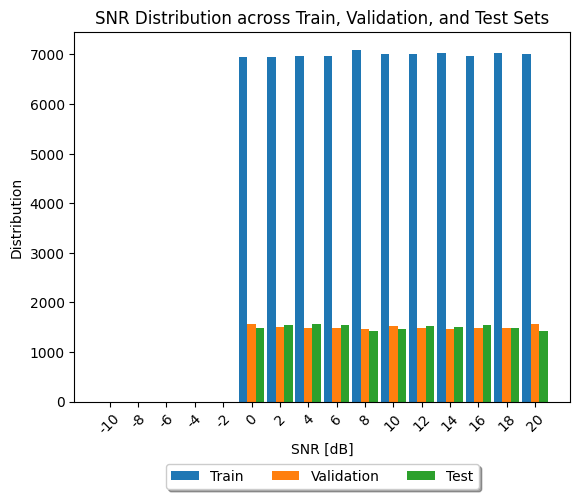

In [ ]:
plot_snr_distribution(train_idx, valid_idx, test_idx, lbl_SNR)

In [ ]:
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)
print(X_train)
print(X_train.shape)

[[[ 0.38140224  1.25191404]
  [ 0.38804221 -0.05818491]
  [-1.27325037  0.33785721]
  ...
  [ 0.3754859   1.08107471]
  [-1.11205262 -1.31293231]
  [-0.34738401  1.39470898]]

 [[ 1.05079983  0.66631994]
  [-0.23252232 -0.91949717]
  [-0.21395351 -0.75275483]
  ...
  [-1.90368585  1.31513334]
  [ 1.23335705  1.4846716 ]
  [-0.32170703 -1.03728079]]

 [[ 0.37616405 -1.28396461]
  [ 1.2892402  -1.46585713]
  [ 0.53870121 -0.15988696]
  ...
  [ 0.25553623  0.24001848]
  [-1.50829681 -2.01750495]
  [-0.23948296 -0.1808953 ]]

 ...

 [[ 0.35809503  1.18759847]
  [ 1.7509616  -0.55799744]
  [ 1.30297896  0.63283754]
  ...
  [ 1.32734971  0.82308265]
  [ 0.37515252 -0.38052867]
  [ 1.20621925  1.62518473]]

 [[ 0.41216821 -0.31717672]
  [ 0.40462976 -0.55685716]
  [ 1.3016505  -0.50631702]
  ...
  [ 1.16810509  1.16400854]
  [ 0.30555209 -1.39333864]
  [ 0.33232224 -1.25791724]]

 [[-0.44913617 -0.21883977]
  [ 0.58471036  1.23035371]
  [ 0.87476617 -0.71171837]
  ...
  [ 0.04631025 -1.058571

# Architectures for training

## CNN

In [ ]:
cnn_in = keras.layers.Input(shape=(128,2)) #(128,2) was here before
cnn = keras.layers.ZeroPadding1D(padding=4)(cnn_in)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Conv1D(filters=50, kernel_size=4, activation='relu')(cnn)
cnn = keras.layers.Dropout(rate=0.6)(cnn)
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)
cnn = keras.layers.Flatten()(cnn)
cnn = keras.layers.Dense(70, activation='selu')(cnn)
cnn_out = keras.layers.Dense(len(mods), activation='softmax')(cnn)

model_cnn = keras.models.Model(cnn_in, cnn_out)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/ColabNotebooks/cnn_model_Created_dataset.tf", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, min_lr=0.000007), # 0.00007 originally, 0.0000007 on created dataset
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)]

optimizer = keras.optimizers.Adam(learning_rate=0.00007) # 0.0007 originally

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


  """
  Credit goes to the original author:

  https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
  """

In [ ]:
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 zero_padding1d_1 (ZeroPadd  (None, 136, 2)            0         
 ing1D)                                                          
                                                                 
 conv1d_3 (Conv1D)           (None, 129, 50)           850       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 64, 50)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 57, 50)            20050     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 28, 50)            0   

In [ ]:
tf.keras.backend.clear_session()
#model_cnn = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/cnn_model_Created_dataset_short.tf")
history = model_cnn.fit(X_train, Y_train, batch_size=16, epochs=20, verbose=1, validation_data= (X_valid, Y_valid), callbacks=callbacks)
# verbose - set at 1 shows many information, set on 2 shows less information

Epoch 1/20
4813/4813 [==============================] - 78s 16ms/step - loss: 0.8863 - accuracy: 0.5660 - val_loss: 0.9069 - val_accuracy: 0.5543 - lr: 2.1000e-05
Epoch 2/20
4813/4813 [==============================] - 72s 15ms/step - loss: 0.8847 - accuracy: 0.5683 - val_loss: 0.9095 - val_accuracy: 0.5558 - lr: 2.1000e-05
Epoch 3/20
4813/4813 [==============================] - 78s 16ms/step - loss: 0.8825 - accuracy: 0.5689 - val_loss: 0.9125 - val_accuracy: 0.5495 - lr: 2.1000e-05
Epoch 4/20
4813/4813 [==============================] - 74s 15ms/step - loss: 0.8817 - accuracy: 0.5705 - val_loss: 0.9167 - val_accuracy: 0.5507 - lr: 2.1000e-05
Epoch 5/20
4813/4813 [==============================] - 73s 15ms/step - loss: 0.8752 - accuracy: 0.5733 - val_loss: 0.9106 - val_accuracy: 0.5550 - lr: 7.0000e-06
Epoch 6/20
4813/4813 [==============================] - 73s 15ms/step - loss: 0.8750 - accuracy: 0.5735 - val_loss: 0.9026 - val_accuracy: 0.5567 - lr: 7.0000e-06
Epoch 7/20
4813/4813 [

Evaluating loaded models

In [ ]:
#model = keras.models.load_model("cnn_model.tf")

# The new short matlab dataset
#model = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/cnn_model_Created_dataset.tf")
# The old short matlab dataset
#model = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/cnn_model_Created_dataset_short.tf")
model = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/cnn_model_2016b_2.tf")

test_loss, test_acc = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

#plt.figure(figsize=(8,6))
#plt.plot(history.history['accuracy'])
#plt.xlabel('n epochs')
#plt.ylabel('accuracy')

#plt.figure(figsize=(8,6))
#plt.plot(history.history['val_accuracy'])
#plt.xlabel('n epochs')
#plt.ylabel('validation accuracy')

5625/5625 [==============================] - 39s 7ms/step - loss: 1.0118 - accuracy: 0.5825
Test accuracy 0.5825111269950867
Test loss 1.0118050575256348



SNR -20dB:
285/285 - 2s - loss: 1.2021 - accuracy: 0.5339 - 2s/epoch - 6ms/step

SNR -18dB:
282/282 - 2s - loss: 1.2351 - accuracy: 0.4887 - 2s/epoch - 6ms/step

SNR -16dB:
283/283 - 2s - loss: 0.8840 - accuracy: 0.5338 - 2s/epoch - 9ms/step

SNR -14dB:
282/282 - 2s - loss: 0.7046 - accuracy: 0.6584 - 2s/epoch - 7ms/step

SNR -12dB:
283/283 - 2s - loss: 1.1460 - accuracy: 0.5325 - 2s/epoch - 5ms/step

SNR -10dB:
281/281 - 2s - loss: 0.9233 - accuracy: 0.6066 - 2s/epoch - 5ms/step

SNR -8dB:
284/284 - 2s - loss: 0.6603 - accuracy: 0.7090 - 2s/epoch - 5ms/step

SNR -6dB:
282/282 - 2s - loss: 1.0496 - accuracy: 0.5769 - 2s/epoch - 7ms/step

SNR -4dB:
283/283 - 2s - loss: 1.3898 - accuracy: 0.5205 - 2s/epoch - 9ms/step

SNR -2dB:
283/283 - 2s - loss: 0.7670 - accuracy: 0.7051 - 2s/epoch - 6ms/step

SNR 0dB:
280/280 - 2s - loss: 1.3975 - accuracy: 0.4682 - 2s/epoch - 5ms/step

SNR 2dB:
281/281 - 2s - loss: 1.0878 - accuracy: 0.4215 - 2s/epoch - 6ms/step

SNR 4dB:
281/281 - 2s - loss: 1.400

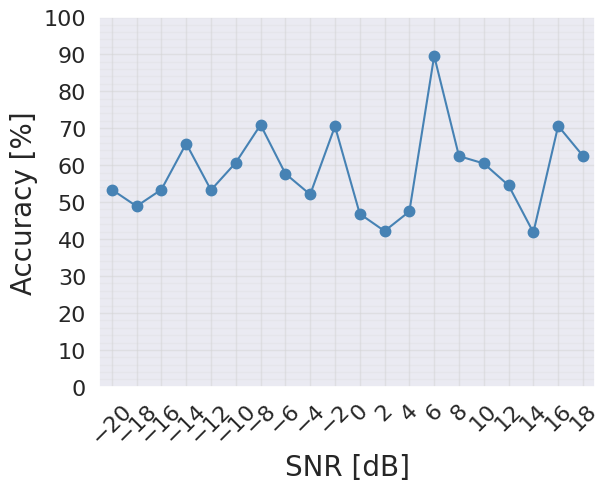

array([0.53392619, 0.488736  , 0.53379124, 0.65839058, 0.53251356,
       0.60664511, 0.70895439, 0.57688463, 0.5205434 , 0.70510834,
       0.46819195, 0.42150968, 0.47467437, 0.89552242, 0.62437892,
       0.6044395 , 0.54521036, 0.41779605, 0.7060895 , 0.62484431])

In [ ]:
SNR_accuracy(SNR, 'CNN')


# Visualize activation and feature map

In [ ]:
model_visualization(1,9000, mods, model)

IndexError: ignored

# Plot Confusion Matrix

5625/5625 [==============================] - 40s 7ms/step


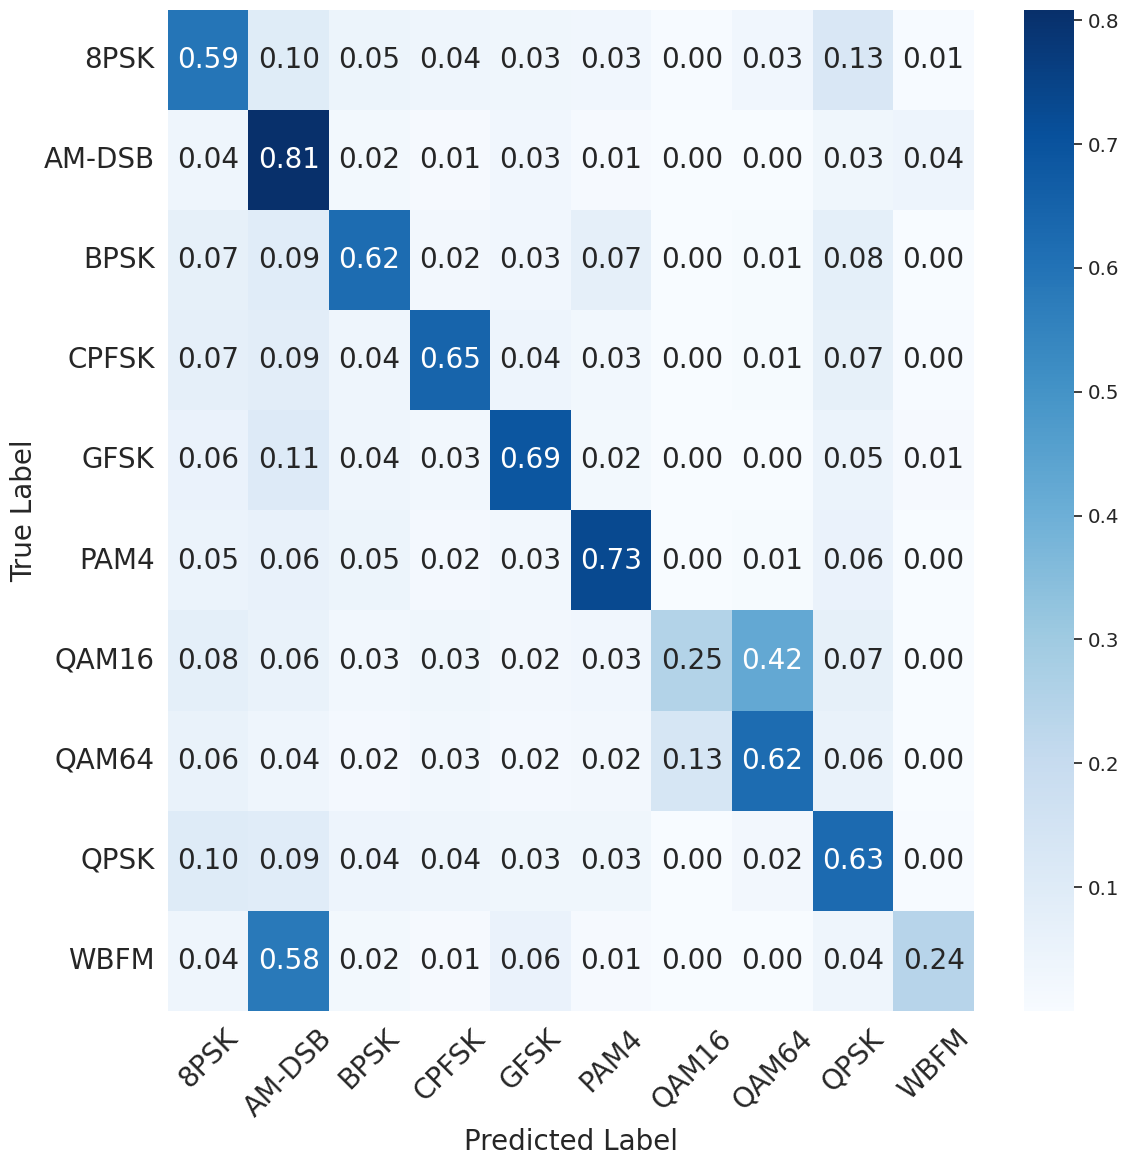

In [ ]:
All_SNR_show_confusion_matrix([X_test], save=False)

516/516 [==============================] - 5s 10ms/step


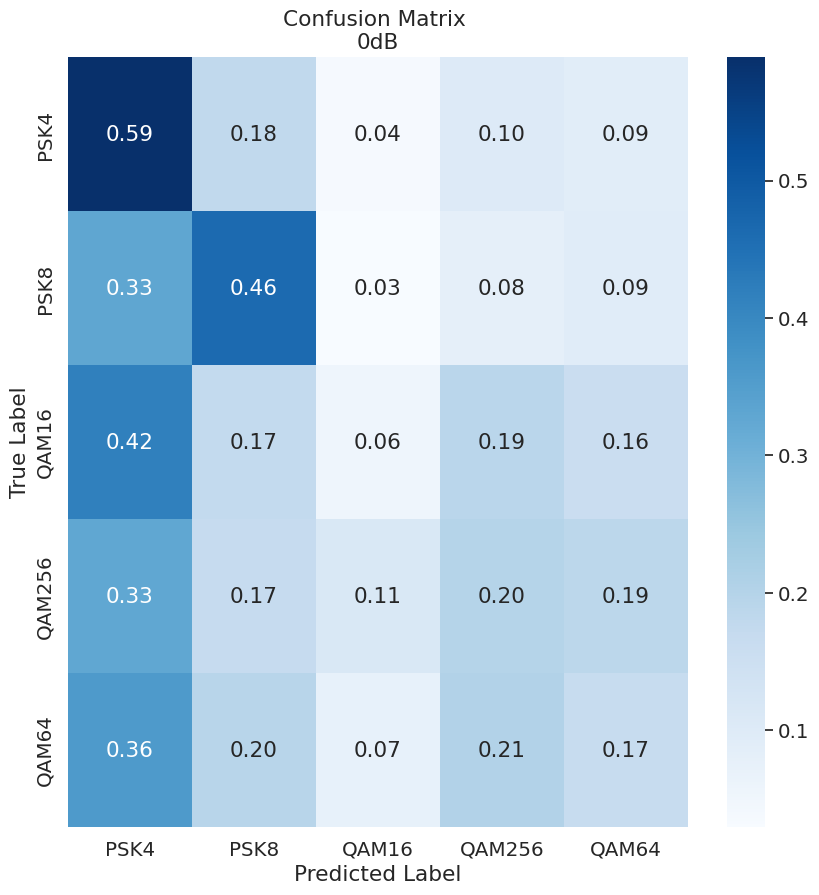

516/516 [==============================] - 4s 7ms/step


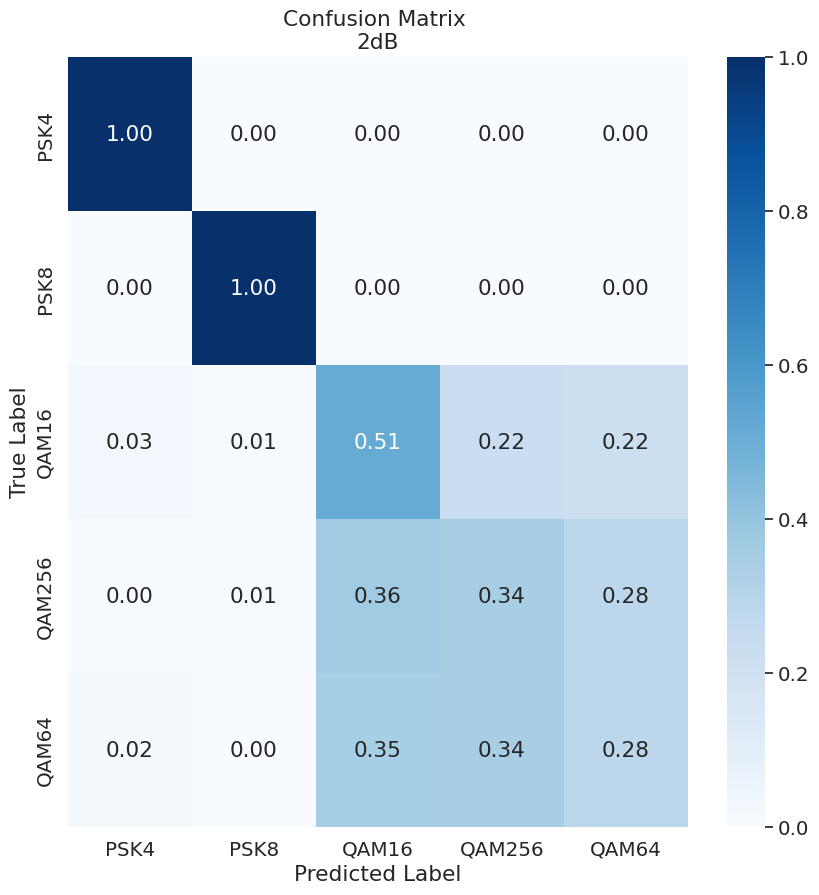

516/516 [==============================] - 4s 7ms/step


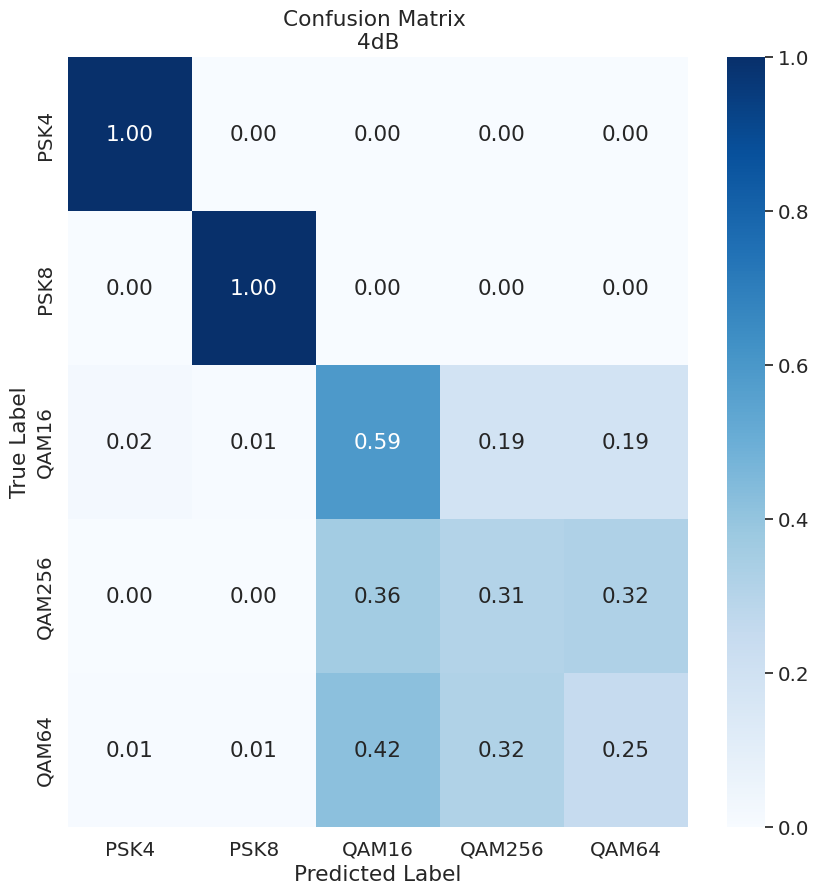

516/516 [==============================] - 5s 10ms/step


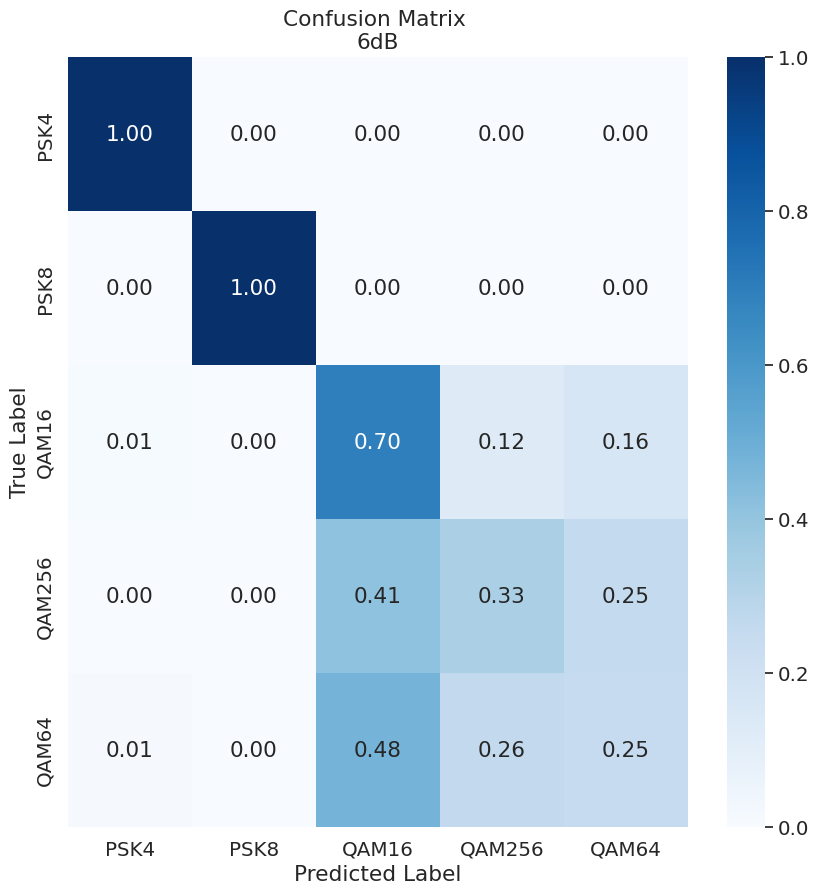

516/516 [==============================] - 4s 7ms/step


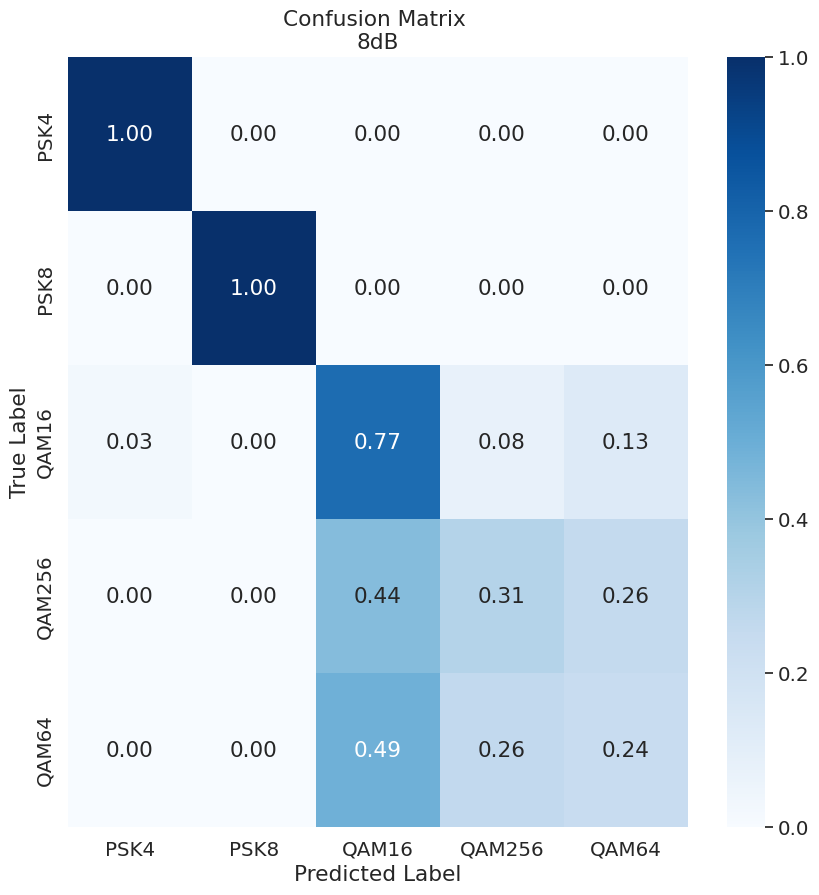

516/516 [==============================] - 5s 10ms/step


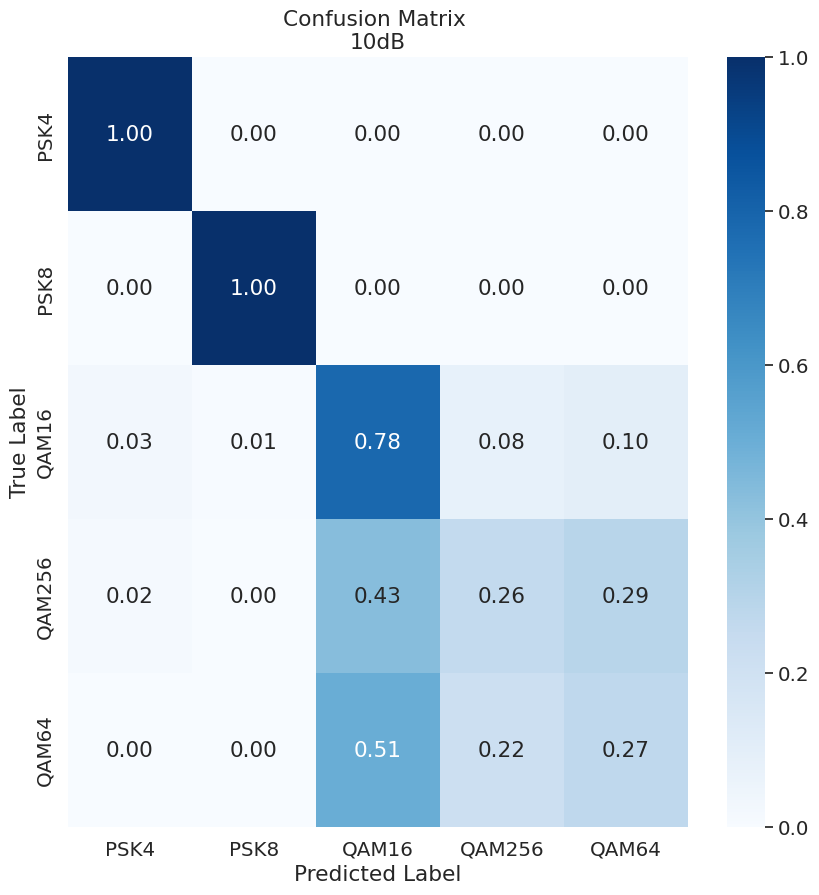

516/516 [==============================] - 4s 7ms/step


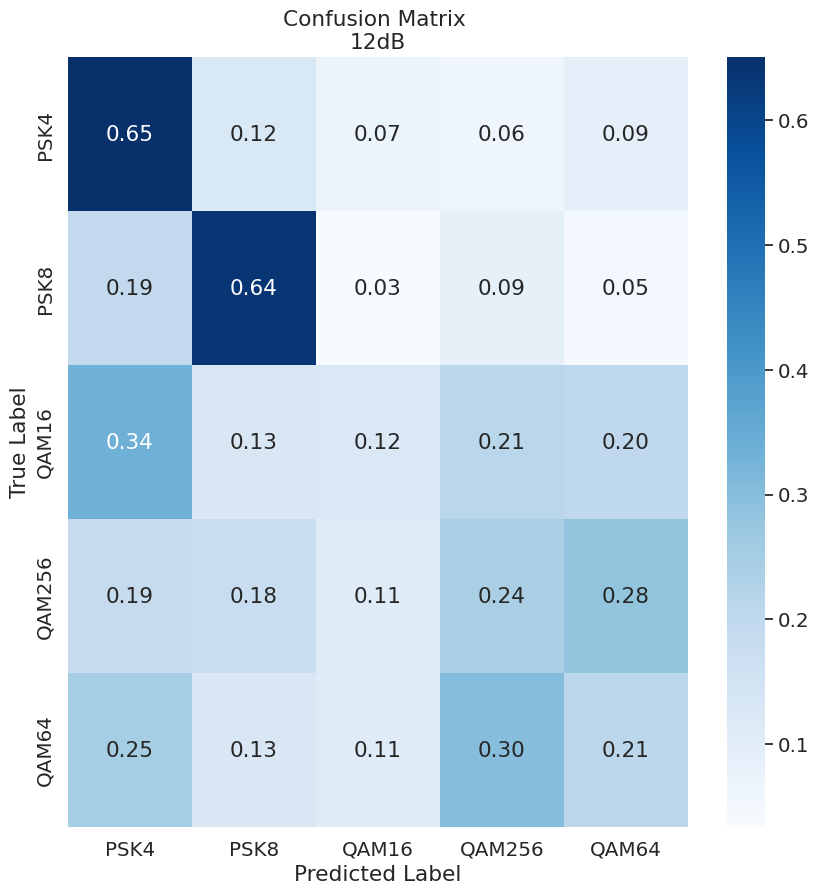

516/516 [==============================] - 4s 7ms/step


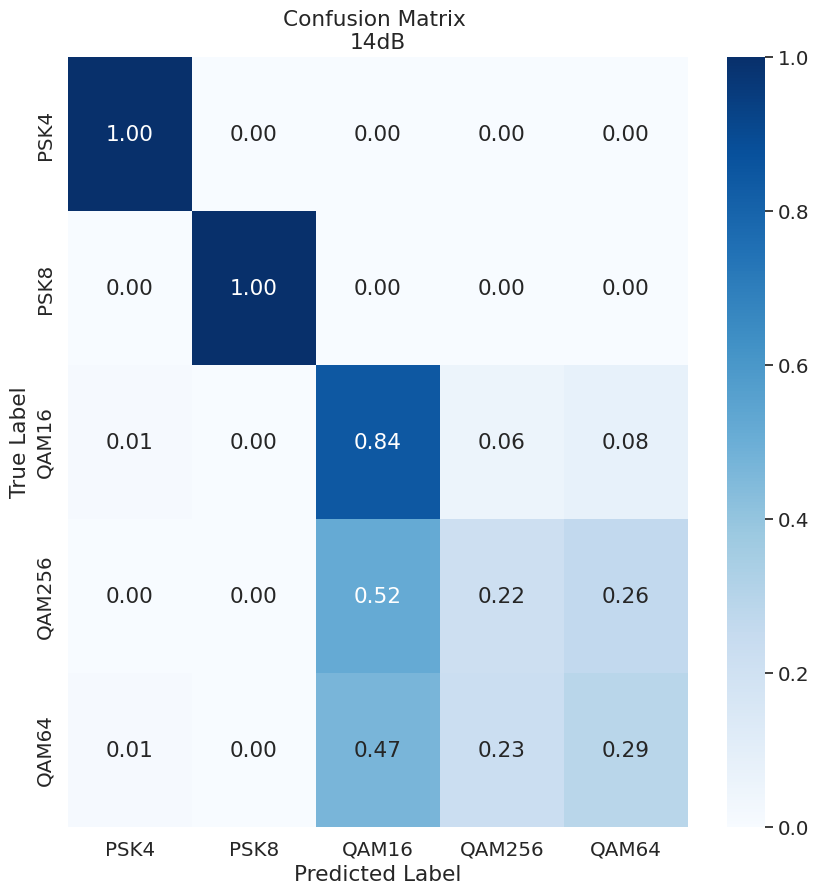

516/516 [==============================] - 5s 10ms/step


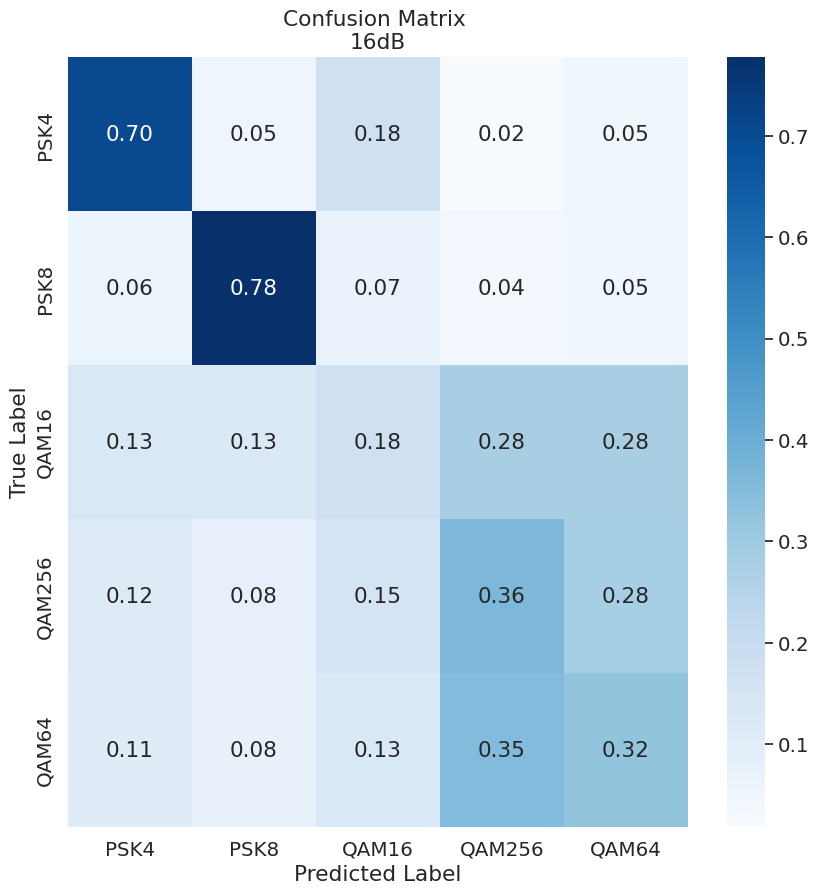

516/516 [==============================] - 4s 8ms/step


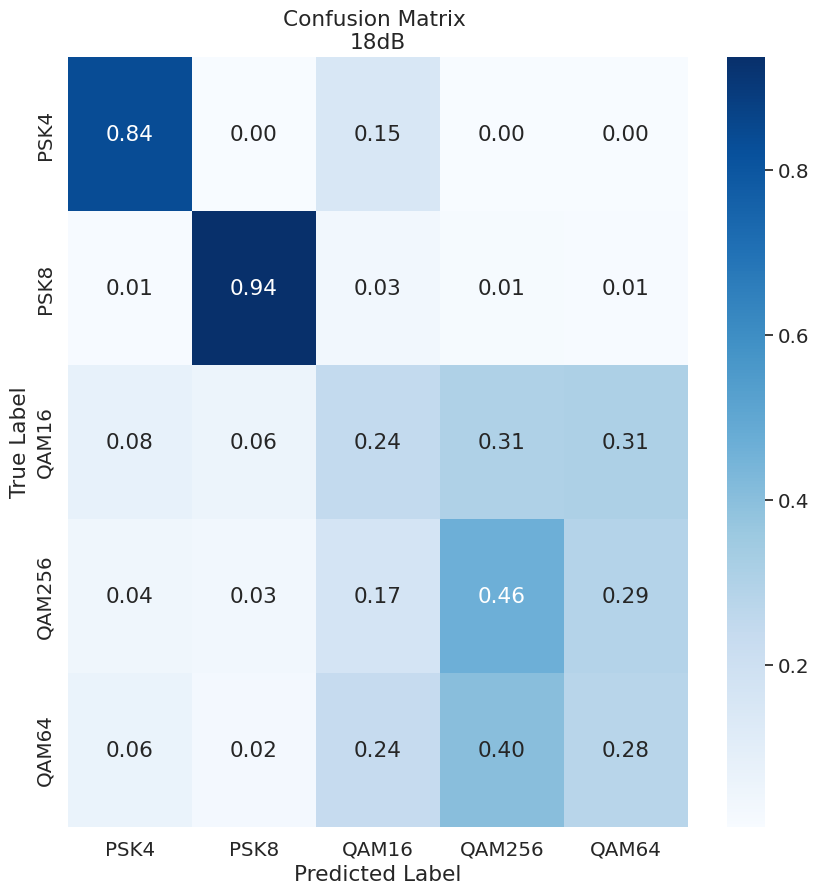

516/516 [==============================] - 5s 10ms/step


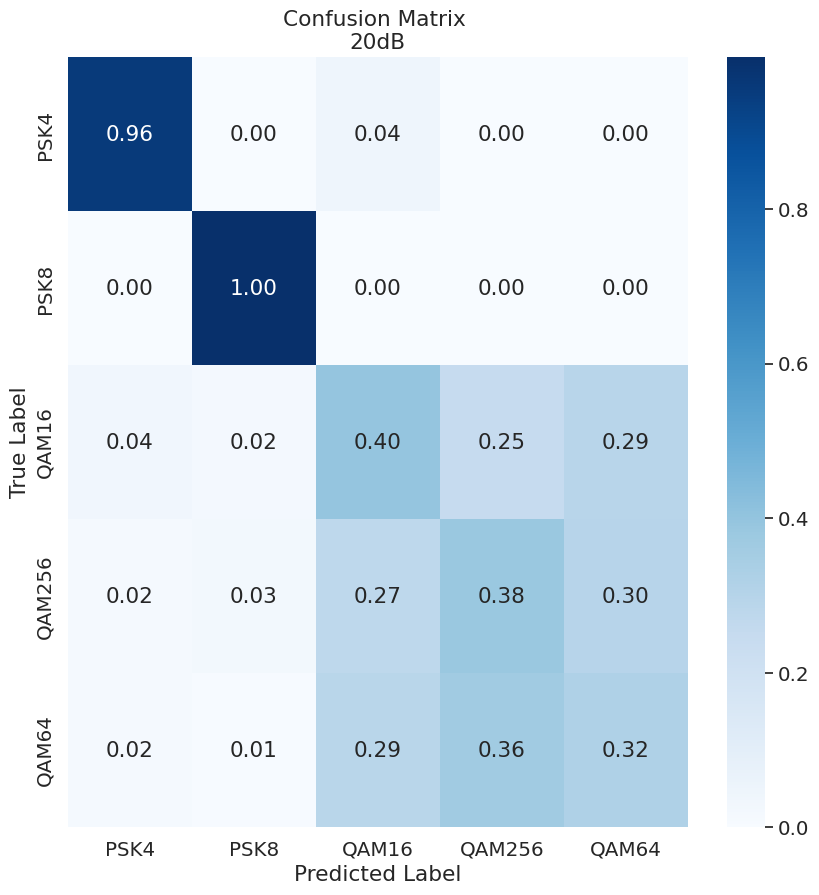

In [ ]:
#SNR_show_confusion_matrix(SNR, lbl_SNR[:], X_test, save=False)